In [59]:
import os, re
import pandas as pd
import numpy as np
from pyfaidx import Fasta 

#a helpful tip: in case you change your _config file while your notebook is running, 
#make sure to reload the _config module when you do, otherwise the variables will get stale
import importlib
import _config
importlib.reload(_config)
from _config import DATA_DIR, OUT_PLACE

from _configpatterns import REGRESSION_TRACK_FILES, CONFIGURATION_NAME, ALL_TRACK_FILES
from _configcompare import COMPARISON_FILES, CONFIGURATION_NAME 

#use your data directory to locate your data files
JEN_DATA_DIR = os.path.join(DATA_DIR,"jen")
COMPARE_DATA_DIR = os.path.join(DATA_DIR,"shibata")
PATTERN_DATA_DIR = os.path.join(DATA_DIR,"mouse")
RAW_DATA_DIR = os.path.join(DATA_DIR, "raw_eccdna")
NOREPEATS_DATA_DIR = os.path.join(DATA_DIR, "no_repeats")
ENCODE_DATA_DIR = os.path.join(DATA_DIR, "encode")

OUT_DIR = os.path.join(OUT_PLACE,"eccdna1_firsttests")
if not os.path.isdir(OUT_DIR): os.makedirs(OUT_DIR)
    
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.backends.backend_pdf import PdfPages
import argparse
import seaborn as sns
%matplotlib inline

/cluster/shz24/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/cluster/shz24/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/cluster/shz24/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/cluster/shz24/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/cluster/shz24/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/cluster/shz24/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 47

In [2]:
files = [rtf['filename'] for rtf in REGRESSION_TRACK_FILES]
allfiles = [rtf['filename'] for rtf in ALL_TRACK_FILES]
filenames = [rtf['name'] for rtf in REGRESSION_TRACK_FILES]
allfilenames = [rtf['name'] for rtf in ALL_TRACK_FILES]

compare_files = [rtf['filename'] for rtf in COMPARISON_FILES]
compare_names = [rtf['name'] for rtf in COMPARISON_FILES]

allowed_chromosomes = [f'chr{x}' for x in (list(range(1,19)) + ['X', 'Y'])]
targetshape = (21, 2000)
zeros = np.zeros(targetshape)
box_smoothing_window = 30

In [3]:
def xvalue(x):
    return 22 if 'X' in x else (23 if 'Y' in x else int(x[3:])-1)

In [4]:
def delimit(file):
    for l in open(file):
        delim = '\t' if re.compile('\t').search(l) else ','
        break
    return delim

In [5]:
def file_process(file):
    big_array = np.zeros(targetshape)
    pattern_path = os.path.join(PATTERN_DATA_DIR, file)
    name = pd.read_csv(pattern_path, delimiter=delimit(pattern_path))
    
    name = name.loc[name.chrom.isin(allowed_chromosomes)]
    name = name.rename(columns = {"chrom":"Chr","chromStart":"FeatureStart","chromEnd":"FeatureEnd"})
    name['FeatureMid100k'] = (name[['FeatureStart', 'FeatureEnd']].mean(axis=1))//1e5
    name_chromosome = pd.concat([name.Chr.apply(xvalue).rename('x'),
                            name.FeatureMid100k.rename('y')], axis=1)
    name_pixels = name_chromosome.groupby(['x','y']).apply(lambda x: x.y.count()) 
    
    namehg_pixels = name_pixels.unstack().fillna(0).values
    if namehg_pixels.size < 48000:
        big_array[0:namehg_pixels.shape[0],0:namehg_pixels.shape[1]] = namehg_pixels
        namehg_pixels = big_array
    else:
        namehg_pixels = namehg_pixels[0:big_array.shape[0],0:big_array.shape[1]]
    return namehg_pixels

In [6]:
def pixel_process(pixels):
    pixels[pixels > 100] = 100
    pixels_smooth = np.mean(np.array([np.roll(pixels,translation) 
                                       for translation in range(box_smoothing_window)]),0)
    #how much to smooth by?
    smooth_binary =1*(pixels_smooth > np.percentile(pixels_smooth,80))
    return smooth_binary

In [7]:
def vectorize(file):
    return np.ndarray.flatten(file_process(file))

def vectorize_all(files):
    result = []
    for file in files:
        result.append(vectorize(file))
    return result

In [8]:
def elasticnet_compare(files, compare_t, transparency2):
    data = pd.DataFrame(np.transpose(vectorize_all(files)+[np.ndarray.flatten(transparency2)]), columns = files + ['eccdna comparison'])
    target = np.ndarray.flatten(compare_t)
    scaler = StandardScaler()
    data_std = scaler.fit_transform(data)
    data_std = pd.DataFrame(data_std, columns = files + ['transparency'])
    X_train, X_test, y_train, y_test = train_test_split(data_std, target, test_size=0.10)
    return linear_model.ElasticNetCV().fit(X_train, y_train)

In [83]:
def lasso(files, transparency2):
    data = pd.DataFrame(np.transpose(vectorize_all(files)), columns = files)
    target = np.ndarray.flatten(transparency2)
    scaler = StandardScaler()
    data_std = scaler.fit_transform(data)
    data_std = pd.DataFrame(data_std, columns = files)
    X_train, X_test, y_train, y_test = train_test_split(data_std, target, test_size=0.10)
    return linear_model.LassoCV().fit(X_train, y_train)

In [9]:
def ridge(files, transparency2):
    data = pd.DataFrame(np.transpose(vectorize_all(files)), columns = files)
    target = np.ndarray.flatten(transparency2)
    scaler = StandardScaler()
    data_std = scaler.fit_transform(data)
    data_std = pd.DataFrame(data_std, columns = files)
    X_train, X_test, y_train, y_test = train_test_split(data_std, target, test_size=0.10)
    return linear_model.RidgeCV().fit(X_train, y_train)

In [10]:
def elasticnet(files, transparency2):
    data = pd.DataFrame(np.transpose(vectorize_all(files)), columns = files)
    target = np.ndarray.flatten(transparency2)
    scaler = StandardScaler()
    data_std = scaler.fit_transform(data)
    data_std = pd.DataFrame(data_std, columns = files)
    X_train, X_test, y_train, y_test = train_test_split(data_std, target, test_size=0.10)
    return linear_model.ElasticNetCV().fit(X_train, y_train)

In [11]:
def process(files, transparency):
    zeros = np.zeros(targetshape)
    processed = []
    for file in files:
        if type(file) == np.ndarray:
            processed.append(file)
        else:
            result = pixel_process(file_process(file))
            processed.append(result)
    while len(processed) < 3:
        processed.append(zeros)
    processed.append(transparency)
    return np.array(processed)

In [12]:
def length_hist(files):
    labels = ['raw eccdna'] + compare_names
    
    fig = plt.figure()
    fig.set_size_inches(10,8)
    
    bins = np.linspace(0, 9000, 100)
    for file in files:
        plt.hist(file.length, bins, edgecolor='black', linewidth=1.2, alpha = 0.5, label = labels.pop(0))
    plt.legend(loc='upper right')
    plt.xlabel('eccdna length in bp')
    plt.tight_layout()

In [13]:
def map_regression_plot(transparency):
    f , ax = plt.subplots(1, 2)
    f.suptitle('Co-occurance of eccdna with various DNA patterns', y=1.0)
    f.set_size_inches(20,8)
    labels = [f"chr{x}" for x in (list(range(1,20)) + ["X","Y"])]

    imaget = np.array(process(files, transparency))
    image = imaget.transpose([1,2,0])

    plt.sca(ax[0])
    ax[0].set_yticks(range(21))
    ticks = ax[0].set_yticklabels(labels)
    ax[0].set_title('Co-occurance of eccdna with all 3 DNA patterns', fontsize=14)
    ax[0].set_xlabel('100kbp bins')
    im = plt.imshow(image, aspect = 'auto')

    values = elasticnet(files, transparency).coef_
#     values = ['%.2f' % elem for elem in values]
    values = list(map(float, values))

    color = ['red', 'green', 'blue']
    df = np.transpose(pd.DataFrame(np.array([values, files, color])))
    df = df.rename(columns = {0:'coef_value', 1:'dataset', 2:'color'})
    df = df.sort_values(by='coef_value', ascending = False).reset_index(drop=True)
    
    plt.sca(ax[1])
    plt.bar(list(range(1, len(df.dataset)+1)), [float(x) for x in df.coef_value], color = df.color)
    ax = plt.gca()
    ax.set_title('Datasets sorted by coefficient calculation from Elastic Net Model', fontsize=14)
    ax.set_xticks(range(1, 4))
    plt.ylim(bottom=0)
    ticks = ax.set_xticklabels(df.dataset)
    
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     labels = [item.get_text() for item in ax.get_yticklabels()]
#     ax.set_yticklabels([str(round(float(label), 2)) for label in labels if label!=''])

    plt.tight_layout()

In [14]:
def map_regression_compare_plot(compare_t, transparency):
    f , ax = plt.subplots(1, 2)
    f.suptitle('Co-occurance of eccdna with various DNA patterns', y=1.0)
    f.set_size_inches(20,8)
    labels = [f"chr{x}" for x in (list(range(1,20)) + ["X","Y"])]

    imaget = np.array(process(files, transparency))
    image = imaget.transpose([1,2,0])

    plt.sca(ax[0])
    ax[0].set_yticks(range(21))
    ticks = ax[0].set_yticklabels(labels)
    ax[0].set_title('Co-occurance of eccdna with all 3 DNA patterns')
    im = plt.imshow(image, aspect = 'auto')

    values = elasticnet_compare(files, compare_t, transparency).coef_
    values = ['%.2f' % elem for elem in values]
    values = list(map(float, values))

    color = ['red', 'green', 'blue', 'grey']
    df = np.transpose(pd.DataFrame(np.array([values, (files + ['compare']), color])))
    df = df.rename(columns = {0:'coef_value', 1:'dataset', 2:'color'})
    df = df.sort_values(by='coef_value', ascending = False).reset_index(drop=True)
    plt.sca(ax[1])
    plt.bar(list(range(1, len(df.dataset)+1)), [float(x) for x in df.coef_value], color = df.color)
    ax = plt.gca()
    ax.set_title('Datasets sorted by coefficient calculation from Elastic Net Model')
    ax.set_xticks(range(1, 5))
    plt.ylim(bottom=0)
    ticks = ax.set_xticklabels(df.dataset)
    
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     labels = [item.get_text() for item in ax.get_yticklabels()]
#     ax.set_yticklabels([str(round(float(label), 2)) for label in labels if label!=''])

    plt.tight_layout()

In [15]:
def feature_cor_plot(allfiles):
    data = pd.DataFrame(np.transpose(vectorize_all(allfiles)), columns = allfiles).transpose()
    corr = np.corrcoef(data)
    fig = plt.figure()
    labels = [x[5:-4] for x in data.index]
    corrmap = sns.heatmap(corr, xticklabels=labels, yticklabels=labels)

In [48]:
def eccdna_cor_plot(pixels):
    flattened = []
    for pixel in pixels:
        flattened.append(np.ndarray.flatten(pixel_process(pixel)))
        
    data = pd.DataFrame(np.transpose(flattened), columns = ['MN', 'ES', 'heart', 'liver', 'brain']).transpose()
    corr = np.corrcoef(data)
    fig = plt.figure()
    labels = ['MN', 'ES','heart', 'liver', 'brain']
    corrmap = sns.heatmap(corr, xticklabels=labels, yticklabels=labels, cmap = 'plasma')

In [79]:
def compare_pixelate(compare_df):
    compare_df['mid100k'] = (compare_df[['start','end']].mean(axis = 1))//1e5
    compare_array = pd.concat([compare_df.chrom.apply(xvalue).rename('x'), 
                       compare_df.mid100k.rename('y'), compare_df.readcount], axis = 1)
    compare_array['abundance1'] = compare_array.groupby(['x', 'y']).transform('count')
    compare_array['readcount'] = compare_array['readcount'] + compare_array['abundance1']
    compare_array = compare_array.drop('abundance1', 1)
    compare_array = compare_array.drop_duplicates(['x', 'y'])
    return compare_array.pivot(index='x', columns='y', values='readcount').fillna(0)
    

In [78]:
def compare_dfmaker(file):
    compare_path = os.path.join(COMPARE_DATA_DIR, file)
    compare_df = pd.read_csv(compare_path, delimiter="\t")
    compare_df.columns = ['chrom','start','end','readcount','extra']
    compare_df = compare_df.drop('extra',1)
    compare_df['length'] = compare_df['end'] - compare_df['start']
    return compare_df

In [19]:
def transparent(pixel):
    transparency = (pixel).values
    big_transparency = np.zeros(targetshape)
    big_transparency[0:transparency.shape[0], 0:transparency.shape[1]] = transparency
    return big_transparency

In [20]:
def eccdna_pixelate(loci):
    loci['mid100k'] = (loci[['start','end']].mean(axis = 1))//1e5
    loci_array = pd.concat([loci.chrom.apply(xvalue).rename('x'), 
                       loci.mid100k.rename('y')], axis = 1)
    
    return loci_array.groupby(['x', 'y']).apply(lambda x: x.y.count()).unstack().fillna(0) 

In [21]:
def eccdna_binary_plot(eccdna_t, compare_t):
    f, ax = plt.subplots(1,1)
    f.suptitle('co-occurance of eccdna regions and particular shibata data', y=1.0)
    f.set_size_inches(20,8)
    labels = [f"chr{x}" for x in (list(range(1,20)) + ["X","Y"])]
    
    imaget = np.array(process([zeros, compare_t, zeros], eccdna_t))
    image = imaget.transpose([1,2,0])
    
    ax.set_yticks(range(21))
    ticks = ax.set_yticklabels(labels)
#     ax.set_title('Co-occurance of eccdna')
    plt.imshow(image, aspect = 'auto')

In [84]:
def all_features_plot(dna_trans, feature_files):
    #figure out how to add the name of the dna in the title -_-
    #just copied everything in here, needs to be cleaned up - this function does not work lol
    f, ax = plt.subplots(1,1)
    f.suptitle('Features sorted by coefficient calculation based on Elastic Net Model', y=1.0)
    f.set_size_inches(20,8)
    
    values = lasso(feature_files, dna_trans).coef_
    print(values)
    values = list(map(float, values))

    df = np.transpose(pd.DataFrame(np.array([values, allfilenames])))
    df = df.rename(columns = {0:'coef_value', 1:'dataset'})
    df = df.sort_values(by='coef_value', ascending = False).reset_index(drop=True)
    
    plt.sca(ax)
    plt.bar(list(range(1, len(df.dataset)+1)), [float(x) for x in df.coef_value])
    ax.set_xticks(range(1, len(df.dataset)+1))
    plt.ylim(bottom=0)
    ticks = ax.set_xticklabels(df.dataset)
    
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     labels = [item.get_text() for item in ax.get_yticklabels()]
#     ax.set_yticklabels([str(round(float(label), 2)) for label in labels if label!=''])

    plt.tight_layout()

In [23]:
def eccdna_scatter_plot():
    ES_path = os.path.join(NOREPEATS_DATA_DIR, "ES-1_norepeats.bed")
    ES_loci = pd.read_csv(ES_path, names = ["chrom", "start", "end", "strand", "event_name", 
                                            "chrom2", "discordant reads"], delimiter = "\t")  
    ES_loci['length'] = ES_loci['end'] - ES_loci['start']
    ES_loci['mid100k'] = (ES_loci[['start','end']].mean(axis = 1))//1e5
    loci_df = pd.concat([ES_loci.chrom.apply(xvalue).rename('x'), 
                           ES_loci.mid100k.rename('y')], axis = 1)

    loci_df = loci_df.groupby(["x", "y"]).apply(lambda x: x.y.count())
    loci_df = loci_df.reset_index(name="count")
    #loci_df has an x (chrom), y (bin) and count column

    raw_path = os.path.join(NOREPEATS_DATA_DIR, "MN-1_norepeats.bed")
    raw_loci = pd.read_csv(raw_path, names = ["chrom", "start", "end", "strand", "event_name", 
                                              "chrom2", "discordant reads"], delimiter = "\t")
    raw_loci['length'] = raw_loci['end'] - raw_loci['start']
    raw_loci['mid100k'] = (raw_loci[['start','end']].mean(axis = 1))//1e5
    raw_df = pd.concat([raw_loci.chrom.apply(xvalue).rename('x'), 
                           raw_loci.mid100k.rename('y')], axis = 1)
    MN_df = raw_df.groupby(["x", "y"]).apply(lambda x: x.y.count())
    MN_df = MN_df.reset_index(name="count2")
    #MN_df has an x (chrom), y (bin) and count column

    s1 = pd.merge(MN_df, loci_df, how='left', on=['x', 'y']).fillna(0)
    
    f = plt.figure()
    f.set_size_inches(8,8)
    f.suptitle('Comparison of unique eccdnas in every 100kb bin between ES and MN cells', y=0.95, fontsize=13)
    plt.scatter(s1['count'], s1['count2'])
    plt.xlabel('Number of unique ES eccdnas at a particular bin')
    plt.ylabel('Number of unique MN eccdnas at a particular bin')

In [24]:
def compare_readcount(compare_df):
    compare_df['mid100k'] = (compare_df[['start','end']].mean(axis = 1))//1e5
    compare_array = pd.concat([compare_df.chrom.apply(xvalue).rename('x'), 
                       compare_df.mid100k.rename('y'), compare_df.abundance], axis = 1)
    compare_array['abundance1'] = compare_array.groupby(['x', 'y']).transform('count')
    compare_array['abundance'] = compare_array['abundance'] + compare_array['abundance1']
    compare_array = compare_array.drop('abundance1', 1)
    compare_array = compare_array.drop_duplicates(['x', 'y'])
    return compare_array

In [25]:
def raw_count(raw_eccdna):
    fpath = os.path.join(RAW_DATA_DIR, raw_eccdna)
    loci = pd.read_csv(fpath, names = ["chrom", "start", "end", "strand", "event_name", 
                                            "chrom2", "discordant reads"], delimiter = "\t")  
    loci['length'] = loci['end'] - loci['start']
    loci['mid100k'] = (loci[['start','end']].mean(axis = 1))//1e5
    loci_df = pd.concat([loci.chrom.apply(xvalue).rename('x'), 
                           loci.mid100k.rename('y')], axis = 1)

    loci_df = loci_df.groupby(["x", "y"]).apply(lambda x: x.y.count())
    loci_df = loci_df.reset_index(name="count")
    return loci_df

In [26]:
def shibata_count(eccdna):
    fpath = os.path.join(COMPARE_DATA_DIR, eccdna)
    loci = pd.read_csv(fpath, names = ["chrom", "start", "end", "reads", "random"], delimiter = "\t")  
    loci['length'] = loci['end'] - loci['start']
    loci['mid100k'] = (loci[['start','end']].mean(axis = 1))//1e5
    loci_df = pd.concat([loci.chrom.apply(xvalue).rename('x'), 
                           loci.mid100k.rename('y')], axis = 1)

    loci_df = loci_df.groupby(["x", "y"]).apply(lambda x: x.y.count())
    loci_df = loci_df.reset_index(name="count")
    return loci_df

In [27]:
def raw_count_100(eccdna):
    fpath = os.path.join(RAW_DATA_DIR, eccdna)
    loci = pd.read_csv(fpath, names = ["chrom", "start", "end", "strand", "event_name", 
                                            "chrom2", "discordant reads"], delimiter = "\t")  
    loci['length'] = loci['end'] - loci['start']
    loci['mid1000'] = (loci[['start','end']].mean(axis = 1))//1e3
    loci_df = pd.concat([loci.chrom.apply(xvalue).rename('x'), 
                           loci.mid1000.rename('y')], axis = 1)

    loci_df = loci_df.groupby(["x", "y"]).apply(lambda x: x.y.count())
    loci_df = loci_df.reset_index(name="count")
    return loci_df

In [93]:
def scatter_plot(raw_eccdna, shibata):
    fig = plt.figure()
    fig.set_size_inches(5,5)
    fig.suptitle('Comparison of unique eccdnas in every 100kb bin between '+shibata[10:-4]+' and '+raw_eccdna[:-4], y=0.95, fontsize=13)
    
    loci_df = raw_count(raw_eccdna)
    
    shibata_df = shibata_count(shibata)
    
    s1 = pd.merge(shibata_df, loci_df, how='left', on=['x', 'y']).fillna(0)
    plt.scatter(s1['count_x'], s1['count_y'])


    plt.xlabel('Number of unique '+shibata[10:-4]+' eccdnas at a particular bin')
    plt.ylabel('Number of unique '+raw_eccdna[:-4]+' eccdnas at a particular bin')
    plt.xlim(0,25)
    plt.ylim(0,25)

In [29]:
def compare_scatter_plot(shibata_1, shibata_2):

    fig = plt.figure()
    fig.set_size_inches(5,5)
    fig.suptitle('Comparison of unique eccdnas in every 100kb bin between '+shibata_1[10:-4]+' and '+shibata_2[10:-4], y=0.95, fontsize=13)
    
    shibata1_df = shibata_count(shibata_1)
    
    shibata2_df = shibata_count(shibata_2)
    
    s1 = pd.merge(shibata1_df, shibata2_df, how='left', on=['x', 'y']).fillna(0)
    plt.scatter(s1['count_x'], s1['count_y'])


    plt.xlabel('Number of unique '+shibata_1[10:-4]+' eccdnas at a particular bin')
    plt.ylabel('Number of unique '+shibata_2[10:-4]+' eccdnas at a particular bin')

In [30]:
def remove_highread(MN):
    fpath = os.path.join(RAW_DATA_DIR, MN)
    loci = pd.read_csv(fpath, names = ["chrom", "start", "end", "strand", "event_name", 
                                            "chrom2", "discordant reads"], delimiter = "\t")  
    loci['length'] = loci['end'] - loci['start']
    loci['mid100k'] = (loci[['start','end']].mean(axis = 1))//1e5
    loci = loci.loc[loci['discordant reads'] > 25]
    loci_df = pd.concat([loci.chrom.apply(xvalue).rename('x'), 
                           loci.mid100k.rename('y')], axis = 1)

    loci_df = loci_df.groupby(["x", "y"]).apply(lambda x: x.y.count())
    loci_df = loci_df.reset_index(name="count")
    return loci_df

In [37]:
def raw_count2(raw_eccdna):
    fpath = os.path.join(JEN_DATA_DIR, raw_eccdna)
    loci = pd.read_csv(fpath, names = ["chrom", "start", "end"], delimiter = "\t")  
    loci['length'] = loci['end'] - loci['start']
    loci['mid100k'] = (loci[['start','end']].mean(axis = 1))//1e5
    loci_df = pd.concat([loci.chrom.apply(xvalue).rename('x'), 
                           loci.mid100k.rename('y')], axis = 1)

    loci_df = loci_df.groupby(["x", "y"]).apply(lambda x: x.y.count())
    loci_df = loci_df.reset_index(name="count")
    return loci_df

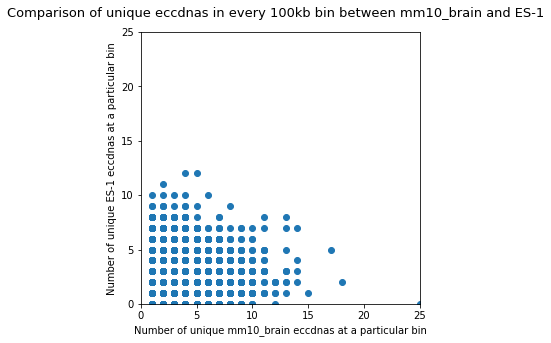

In [94]:
scatter_plot("ES-1.bed", "converted_mm10_brain.bed")

In [ ]:
def encode_processdata(data):
    fpath = os.path.join(ENCODE_DATA_DIR, data)
    loci = pd.read_csv(fpath, names = ["chrom", "start", "end", "name", "score","strand", "sigval",
                                      "pval", "qval"], delimiter = "\t")
    loci["length"] = loci["end"] - loci["start"]
    loci["chrom"] = loci.chrom.apply(xvalue)
    loci["bin"] = (loci[["start","end"]].mean(axis = 1))//1e5
    loci = loci.groupby(["chrom", "bin"]).apply(lambda x: x.length.sum()/1e3) #gives percentages
    loci = loci.reset_index(name = "percent_cov")
    return loci

In [ ]:
def encode_plot():
    MN = encode_processdata("MN_ENCFF840MRT.bed")
    ES = encode_processdata("ES_ENCFF319IPQ.bed")

#     ES = ES.iloc[0:(ES[ES.chrom == 1].index[0])]
#     MN = MN.iloc[0:(MN[MN.chrom == 1].index[0])]
    
    for chrom, ES_chrom in ES.groupby('chrom'):
        if chrom == 5:
            break
        MN_chrom = MN.loc[MN.chrom==chrom]
        f = plt.figure()
        f.suptitle("Chromosome " + str(chrom+1) + " DNase-seq comparison between MN and ES mm10", 
                   y=0.95, fontsize=16)
        f.set_size_inches(20,8)
        plt.bar(MN_chrom.bin, MN_chrom.percent_cov, color='b', alpha = 0.5, label='MN')
        plt.bar(ES_chrom.bin, ES_chrom.percent_cov, color='r', alpha=0.5, label='ES')
        plt.xlabel("100kbp bins", fontsize = 14)
        plt.ylabel("percentage of bin covered by DNase-seq peaks (open chromatin)", fontsize=14)
        
        ax = plt.gca()
        ax.set_facecolor("white")
        plt.legend()
        plt.show()

In [ ]:
def get_bins(data, chromnum):
    """
    Now as percentages: add more documentation please :(
    """
    fpath = os.path.join(ENCODE_DATA_DIR, data)
    loci = pd.read_csv(fpath, names = ["chrom", "start", "end", "name", "score","strand", "sigval",
                                          "pval", "qval"], delimiter = "\t")
    loci = loci.loc[(loci.start>71520000)&(loci.start<71580000)&(loci.chrom==chromnum)]
    max_pos = loci.end.max()
    binsize = 1000

    bins =pd.Series(index = np.arange(0,max_pos, binsize))
    bins = bins.fillna(0)

    for i,l in loci.iterrows():
        first_bin = l.start//binsize
        last_bin =l.end//binsize
        for b in range(first_bin,last_bin+1):
            start_in_bin = max(b*binsize,l.start)
            end_in_bin = min((b+1)*binsize-1 , l.end)
            bins.loc[b*binsize] += (end_in_bin - start_in_bin)/1e1
    return bins

In [ ]:
def binned_count(data, chromnum, start, end):
    """
    Returns: dataframe of unique eccdnas within a small region of the genome
    
    needs to be able to handle --> scenario where there are no unique eccdnas --> not implemented yet
    
    Precondition: 
    chromnum is a string representing a chromosome of form 'chr2'
    start and end are integers
    data is a bed file 
    """
    fpath = os.path.join(NOREPEATS_DATA_DIR, data)
    loci = pd.read_csv(fpath, names = ["chrom", "start", "end", "strand", "event_name", 
                                            "chrom2", "discordant reads"], delimiter = "\t")  
    loci = loci.loc[(loci.start>start)&(loci.start<end)&(loci.chrom==chromnum)]

    loci['mid1000'] = (loci[['start','end']].mean(axis = 1))//1e3
    chrom_bin = pd.concat([loci.chrom.rename('x'), 
                           loci.mid1000.rename('y')], axis = 1)

    chrom_bin = chrom_bin.groupby(["x", "y"]).apply(lambda x: x.y.count())
    chrom_bin = chrom_bin.reset_index(name="count")
    return chrom_bin

In [ ]:
MN_bins = get_bins("MN_ENCFF840MRT.bed", "chr2")
ES_bins = get_bins("ES_ENCFF319IPQ.bed", "chr2")

In [ ]:
refseq = pd.read_csv("/cluster/bh0085/genomes/mm10_refseq.csv", delimiter = "\t")
gene_bounds =pd.concat([refseq.groupby("name2").cdsStart.min().rename("start"),
                    refseq.groupby("name2").cdsEnd.max().rename("end"),
                   refseq.groupby("name2").chrom.first().rename("chrom"),
                   refseq.groupby("name2").strand.first().rename("strand")], axis = 1)
gene_bounds = gene_bounds.loc[gene_bounds.end-gene_bounds.start < 1000000]
gene_region = gene_bounds.loc[(gene_bounds.start<71580000)&(gene_bounds.end>71520000)&
                             (gene_bounds.chrom == 'chr2')]

In [ ]:
#makes a plot --> turn into function 
start = 71520000
end = 71580000
MN_chr2_count = binned_count('MN-1_norepeats.bed', 'chr2', start, end)
plt.plot(MN_bins.loc[start:])
plt.plot(ES_bins.loc[start:])
plt.plot(MN_chr2_count.y*1000, MN_chr2_count['count']*25, "*")
for i in range(len(gene_region)):
    plt.plot(gene_region[["start","end"]].values[i],[30,30],label=gene_region.iloc[i].name)
plt.legend()
plt.xlabel('location in bp')
# plt.ylabel()
ax=plt.gca()
xlim=ax.set_xlim(start, end)

In [ ]:
# script that outputs specific regions of high dif:


In [81]:
def create_figure(tracks, eccdna, raw_eccdna, compare_files):
    with PdfPages(os.path.join(OUT_DIR,"eccdna1_figures_"+CONFIGURATION_NAME+'.pdf')) as pdf:
    
        #Jen's eccdna data
        fpath = os.path.join(JEN_DATA_DIR, eccdna)
        loci = pd.read_csv(fpath, names = ["chrom","start","end"], delimiter="\t")
        loci['length'] = loci['end'] - loci['start']
        pixels = eccdna_pixelate(loci)
        transparency = transparent(pixels)
        
        # map_regression_plot(transparency)
        # all_features_plot(transparency, allfiles)
    
    
        #Jen's raw eccdna data
        raw_path = os.path.join(RAW_DATA_DIR, raw_eccdna)
        raw_loci = pd.read_csv(raw_path, names = ["chrom", "start", "end", "strand", "event_name", 
                                                  "chrom2", "readcount"], delimiter = "\t")
        raw_loci['length'] = raw_loci['end'] - raw_loci['start']
        raw_eccdna_pixels = compare_pixelate(raw_loci)
        raw_transparency = transparent(pixels)

        # map_regression_plot(raw_transparency)
        all_features_plot(raw_transparency, allfiles)
        
        
        
        #pixel and file accumulators
        correlate_data = [transparency, raw_transparency]
        length_hist_data = [raw_loci]
        #length_hist([loci])
        #length_hist([raw_loci])
        
        
        #Shibata comparison data
        for compare in compare_files:
            compare_file = compare_dfmaker(compare)
            
            length_hist_data.append(compare_file)
            
            compare_pixels = compare_pixelate(compare_file)
            compare_transparency = transparent(compare_pixels)
            
            correlate_data.append(compare_transparency)
            all_features_plot(compare_transparency, allfiles)
            
#             pdf.savefig(eccdna_binary_plot(transparency, compare_transparency))
#             pdf.savefig(map_regression_plot(compare_transparency))
#         eccdna_cor_plot(correlate_data)
#         length_hist(length_hist_data)
#         pdf.savefig(feature_cor_plot(allfiles))

[ 0.08311558  0.04697293 -0.00703029  0.08054204  0.17140291  0.30407159]
[18.64197229  0.         -0.          1.96961436 -0.         87.06873501]
[38.20641936  0.         -0.          6.82725574 -0.         11.51204022]
[ 6.49213885  7.13911085 -0.         23.07940662  6.43379759  0.        ]


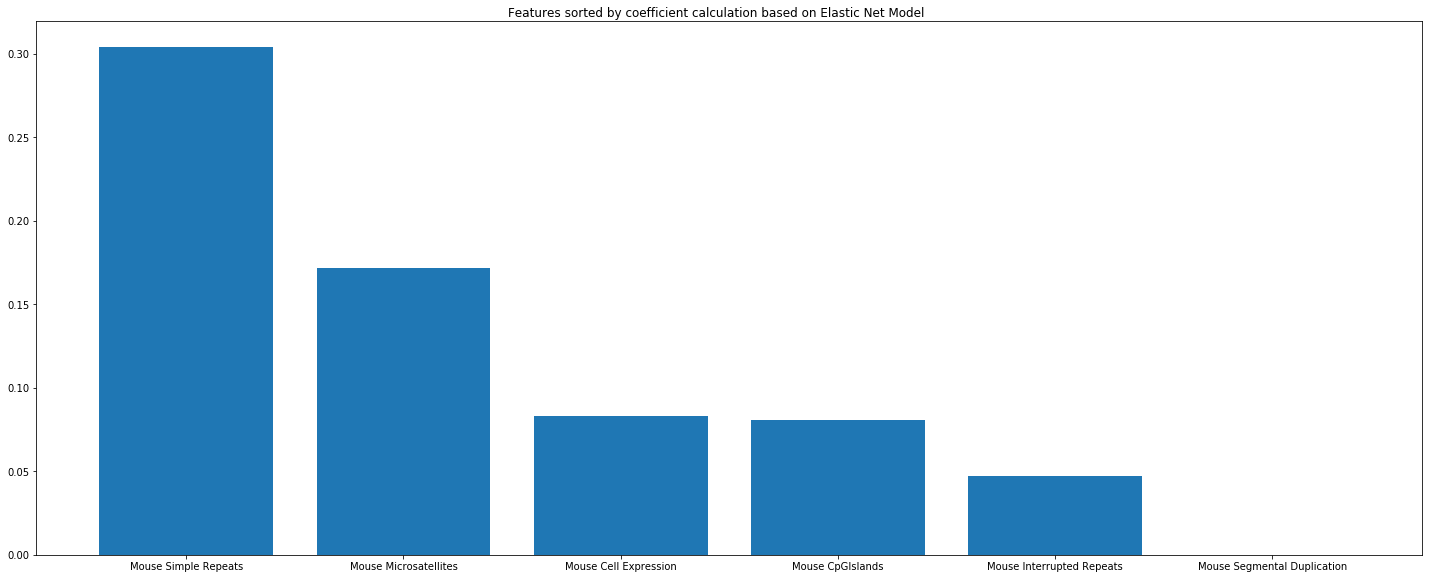

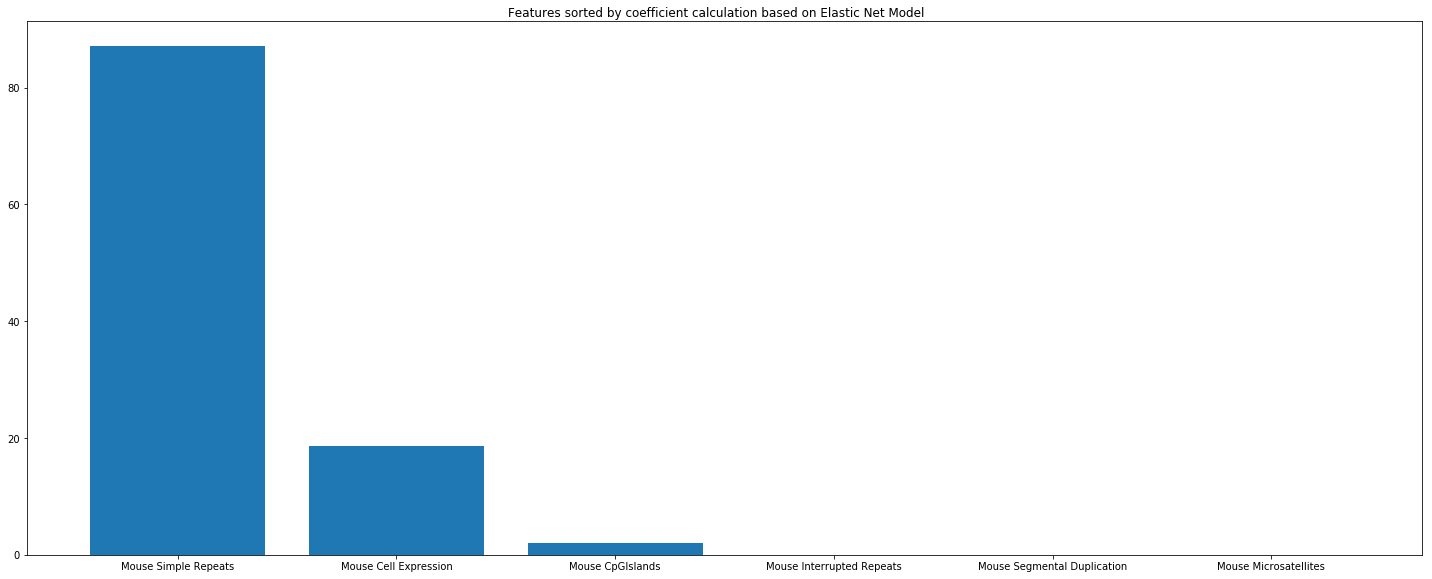

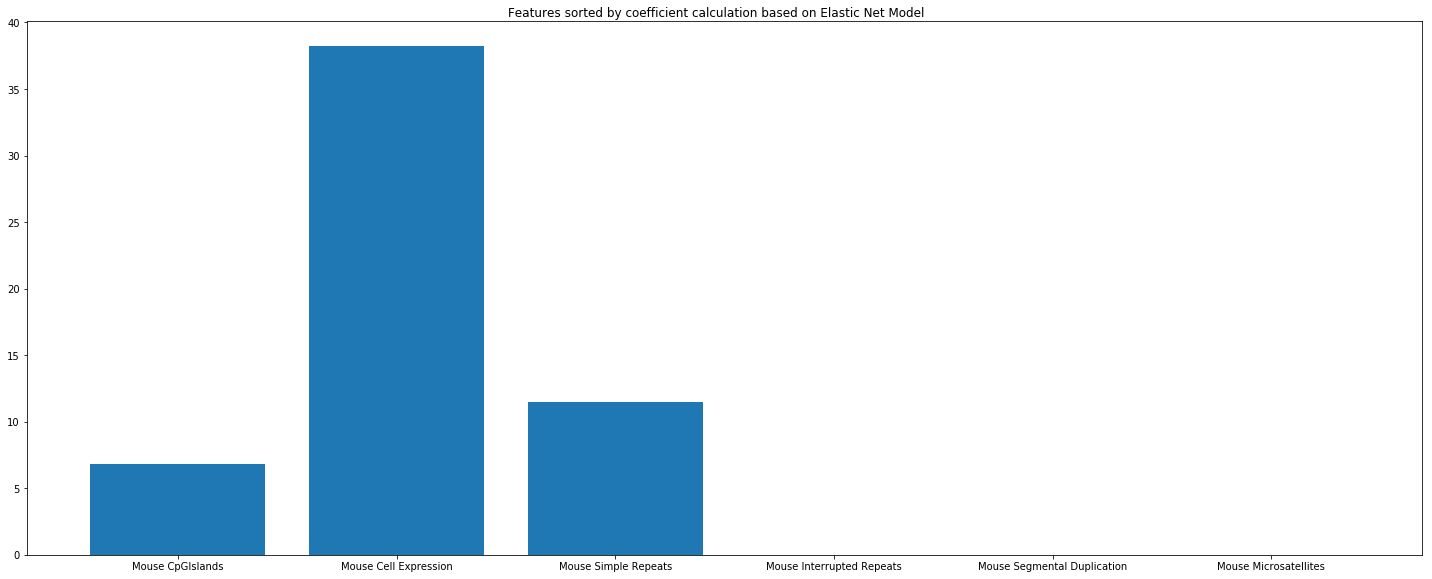

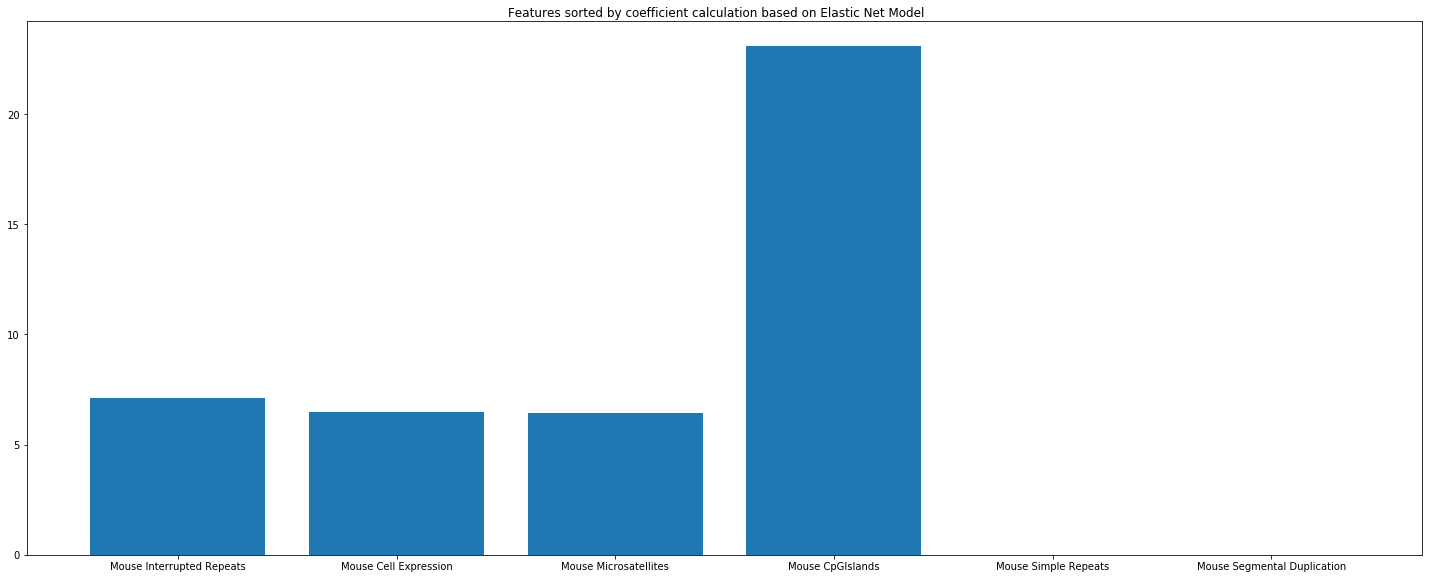

In [85]:
create_figure(REGRESSION_TRACK_FILES, "low_conf_MN-de.bed", "ES-1.bed", compare_files)

In [ ]:
##
# notice that there are several eccdna files to choose from:
# [high_conf.bed  high_conf_MN-de.bed  low_conf.bed  low_conf_MN-de.bed  mid_conf.bed  mid_conf_MN-de.bed]
## 

#I am loading high confidence Motor Neuron (MN) dnas here:
fpath = os.path.join(JEN_DATA_DIR, "high_conf_MN-de.bed")
loci = pd.read_csv(fpath, names = ["chrom","start","end"],delimiter="\t")

#But you can try the mid_conf_MN-de.bed file too!

the rest is all up to your imagination :)
